# Imports

In [1]:
import importlib.resources as resources
import numpy as np
import pydot

from anypick_dk.constants import (
    IIWA_LEN, q_BotShelfPlace, q_MidShelfPlace, q_Object, q_TopShelfPlace,
    WSG_CLOSED, WSG_LEN, WSG_OPENED, WSG_VEL_BOUND
)
from anypick_dk.planner import Planner
from anypick_dk.sim_environment import SimEnvironment
from anypick_dk.utils import concat_iiwa_traj, concat_wsg_traj, create_wsg_traj
from IPython.display import SVG, display
from pydrake.all import GcsTrajectoryOptimization, HPolyhedron, LoadIrisRegionsYamlFile, Point
Subgraph = GcsTrajectoryOptimization.Subgraph

# Simulation Environment Setup

In [2]:
scenario_file = str(resources.files("anypick_dk") / "scenarios" / "shelf_with_objects.yaml")
sim_env = SimEnvironment(scenario_file)
planner = Planner(sim_env)
sim_env.publish_diagram()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Create GCS Graph

In [22]:
def create_base_gcs(iris_regions: dict[HPolyhedron],
                    sim_env: SimEnvironment) -> tuple[GcsTrajectoryOptimization, dict[Subgraph]]:

    gcs = GcsTrajectoryOptimization(IIWA_LEN + WSG_LEN)

    nodes = {
        "start": gcs.AddRegions(
            [iris_regions["start_region"]], order=1, name="start"
        ),
        "home": gcs.AddRegions(
            [iris_regions["home_region"]], order=1, name="home"
        ),
        "transition": gcs.AddRegions(
            [iris_regions["transition_region"]], order=1, name="transition"
        ),
        "top_shelf": gcs.AddRegions(
            [iris_regions["top_shelf_region"]], order=1, name="top_shelf"
        ),
        "top_shelf_approach": gcs.AddRegions(
            [iris_regions["top_shelf_approach_region"]], order=1, name="top_shelf_approach"
        ),
        "mid_shelf": gcs.AddRegions(
            [iris_regions["mid_shelf_region"]], order=1, name="mid_shelf"
        ),
        "mid_shelf_approach": gcs.AddRegions(
            [iris_regions["mid_shelf_approach_region"]], order=1, name="mid_shelf_approach"
        ),
        "bot_shelf": gcs.AddRegions(
            [iris_regions["bot_shelf_region"]], order=1, name="bot_shelf_region"
        ),
        "bot_shelf_approach": gcs.AddRegions(
            [iris_regions["bot_shelf_approach_region"]], order=1, name="bot_shelf_approach"
        ),
        "object": gcs.AddRegions(
            [iris_regions["object_region"]], order=1, name="object"
        ),
        "top_shelf_place": gcs.AddRegions(
            [Point(np.concat([q_TopShelfPlace, np.zeros(WSG_LEN)]))], order=0, name="top_shelf_place"
        ),
        "mid_shelf_place": gcs.AddRegions(
            [Point(np.concat([q_MidShelfPlace, np.zeros(WSG_LEN)]))], order=0, name="mid_shelf_place"
        ),
        "bot_shelf_place": gcs.AddRegions(
            [Point(np.concat([q_BotShelfPlace, np.zeros(WSG_LEN)]))], order=0, name="bot_shelf_place"
        )
    }

    gcs.AddEdges(nodes["start"], nodes["home"])

    gcs.AddEdges(nodes["home"], nodes["object"])
    gcs.AddEdges(nodes["object"], nodes["home"])

    gcs.AddEdges(nodes["home"], nodes["top_shelf_approach"])
    gcs.AddEdges(nodes["top_shelf_approach"], nodes["home"])

    gcs.AddEdges(nodes["home"], nodes["mid_shelf_approach"])
    gcs.AddEdges(nodes["mid_shelf_approach"], nodes["home"])

    gcs.AddEdges(nodes["home"], nodes["transition"])
    gcs.AddEdges(nodes["transition"], nodes["home"])

    gcs.AddEdges(nodes["transition"], nodes["bot_shelf_approach"])
    gcs.AddEdges(nodes["bot_shelf_approach"], nodes["transition"])

    gcs.AddEdges(nodes["top_shelf_approach"], nodes["top_shelf"])
    gcs.AddEdges(nodes["top_shelf"], nodes["top_shelf_approach"])

    gcs.AddEdges(nodes["mid_shelf_approach"], nodes["mid_shelf"])
    gcs.AddEdges(nodes["mid_shelf"], nodes["mid_shelf_approach"])

    gcs.AddEdges(nodes["bot_shelf_approach"], nodes["bot_shelf"])
    gcs.AddEdges(nodes["bot_shelf"], nodes["bot_shelf_approach"])

    gcs.AddEdges(nodes["top_shelf"], nodes["top_shelf_place"])
    gcs.AddEdges(nodes["top_shelf_place"], nodes["top_shelf"])

    gcs.AddEdges(nodes["mid_shelf"], nodes["mid_shelf_place"])
    gcs.AddEdges(nodes["mid_shelf_place"], nodes["mid_shelf"])

    gcs.AddEdges(nodes["bot_shelf"], nodes["bot_shelf_place"])
    gcs.AddEdges(nodes["bot_shelf_place"], nodes["bot_shelf"])

    gcs.AddTimeCost()
    lb = sim_env.plant.GetVelocityLowerLimits()[:IIWA_LEN + WSG_LEN] / 8
    lb[~np.isfinite(lb)] = -WSG_VEL_BOUND
    ub = sim_env.plant.GetVelocityUpperLimits()[:IIWA_LEN + WSG_LEN] / 8
    ub[~np.isfinite(ub)] = WSG_VEL_BOUND
    gcs.AddVelocityBounds(lb, ub)
    return gcs, nodes

def show_gcs_graph(gcs: GcsTrajectoryOptimization) -> None:
    display(SVG(pydot.graph_from_dot_data(gcs.GetGraphvizString())[0].create_svg()))

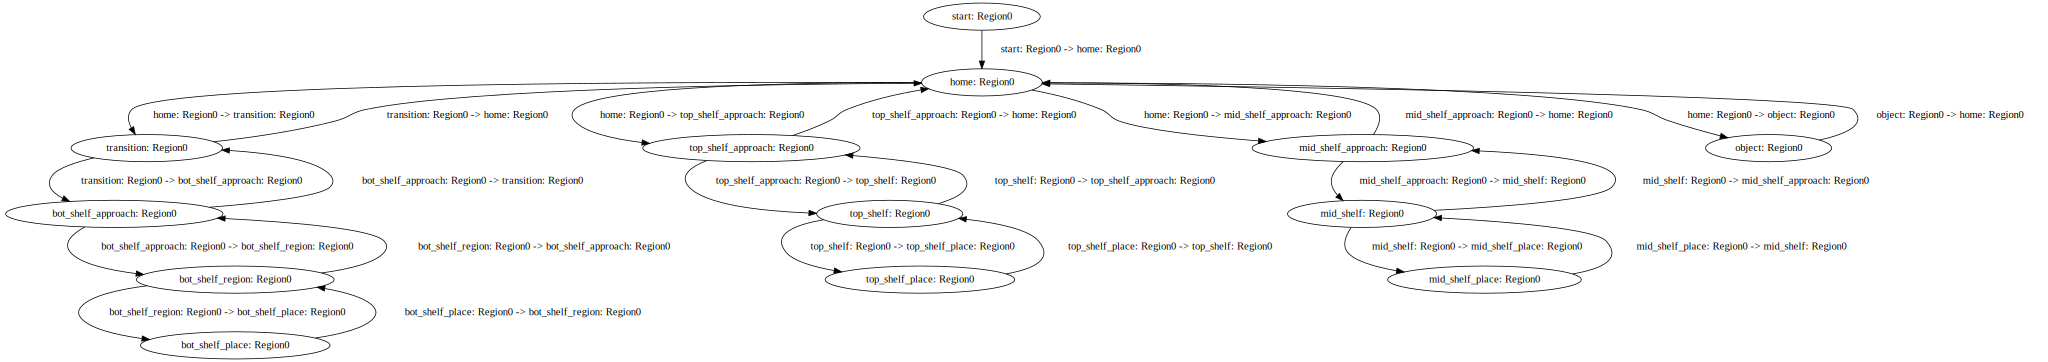

In [8]:
iris_regions_file = str(resources.files("anypick_dk") / "iris_regions" / "shelf_regions.yaml")
iris_regions = LoadIrisRegionsYamlFile(iris_regions_file)
gcs, nodes = create_base_gcs(iris_regions, sim_env)
planner.set_base_gcs(gcs)
show_gcs_graph(gcs)

# Plan a Path

In [9]:
object_point_node = gcs.AddRegions([Point(np.concat([q_Object, np.zeros(WSG_LEN)]))], order=0, name="object_point")
gcs.AddEdges(object_point_node, nodes["object"])
gcs.AddEdges(nodes["object"], object_point_node)
sim_env.set_iiwa_position(q_Object)
sim_env.publish_diagram()

In [10]:
obj_to_top_traj = planner.solve_gcs(object_point_node, nodes["top_shelf_place"])
obj_to_top_wsg = create_wsg_traj(obj_to_top_traj.end_time(), WSG_CLOSED, WSG_CLOSED, WSG_OPENED)

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with Clp.
INFO:anypick_dk.planner:GCS path successfully found


In [11]:
sim_env.visualize_traj(obj_to_top_traj)

In [12]:
obj_to_mid_traj = planner.solve_gcs(object_point_node, nodes["mid_shelf_place"])
obj_to_mid_wsg = create_wsg_traj(obj_to_mid_traj.end_time(), WSG_CLOSED, WSG_CLOSED, WSG_OPENED)

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with Clp.
INFO:anypick_dk.planner:GCS path successfully found


In [13]:
sim_env.visualize_traj(obj_to_mid_traj)

In [14]:
obj_to_bot_traj = planner.solve_gcs(object_point_node, nodes["bot_shelf_place"])
obj_to_bot_wsg = create_wsg_traj(obj_to_bot_traj.end_time(), WSG_CLOSED, WSG_CLOSED, WSG_OPENED)

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with Clp.
INFO:anypick_dk.planner:GCS path successfully found


In [15]:
sim_env.visualize_traj(obj_to_bot_traj)

In [16]:
mid_to_obj_traj = planner.solve_gcs(nodes["mid_shelf_place"], object_point_node)
mid_to_obj_wsg = create_wsg_traj(mid_to_obj_traj.end_time(), WSG_OPENED, WSG_OPENED, WSG_CLOSED)

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 1 unique paths, discarded 99 duplicate paths.
INFO:drake:Finished 1 rounding solutions with Clp.
INFO:anypick_dk.planner:GCS path successfully found


In [17]:
sim_env.visualize_traj(mid_to_obj_traj)

In [18]:
backforth_traj = concat_iiwa_traj(obj_to_mid_traj, mid_to_obj_traj)
backforth_wsg = concat_wsg_traj(obj_to_mid_wsg, mid_to_obj_wsg)

In [19]:
sim_env.visualize_traj(backforth_traj)

# Using the HardwareStation Controller

In [20]:
sim_env.build_diagram_with_controller(obj_to_top_traj, obj_to_top_wsg)

In [21]:
sim_env.set_iiwa_position(q_Object)
sim_env.set_wsg_position(WSG_OPENED)
sim_env.publish_diagram()
sim_env.simulate()

INFO:anypick_dk.sim_environment:Simulation will run for 9.7414839839348 seconds


In [48]:
sim_env.build_diagram_with_controller(obj_to_mid_traj, obj_to_mid_wsg)

In [49]:
sim_env.set_iiwa_position(q_Object)
sim_env.set_wsg_position(WSG_OPENED)
sim_env.publish_diagram()
sim_env.simulate()

INFO:anypick_dk.sim_environment:Simulation will run for 6.575122917505708 seconds


In [50]:
sim_env.build_diagram_with_controller(obj_to_bot_traj, obj_to_bot_wsg)

In [51]:
sim_env.set_iiwa_position(q_Object)
sim_env.set_wsg_position(WSG_OPENED)
sim_env.publish_diagram()
sim_env.simulate()

INFO:anypick_dk.sim_environment:Simulation will run for 8.109920346975088 seconds


In [52]:
sim_env.build_diagram_with_controller(mid_to_obj_traj, mid_to_obj_wsg)

In [53]:
sim_env.set_iiwa_position(q_MidShelfPlace)
sim_env.set_wsg_position(WSG_OPENED)
sim_env.publish_diagram()
sim_env.simulate()

INFO:anypick_dk.sim_environment:Simulation will run for 6.575122917567684 seconds


In [54]:
sim_env.build_diagram_with_controller(backforth_traj, backforth_wsg)

In [55]:
sim_env.set_iiwa_position(q_Object)
sim_env.set_wsg_position(WSG_OPENED)
sim_env.publish_diagram()
sim_env.simulate()

INFO:anypick_dk.sim_environment:Simulation will run for 12.150245835073392 seconds
